## Regression in Python

In [1]:
import pandas as pd
import math
import numpy as np
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns

from cancerolstools import preprocess as pp
from cancerolstools import ols as ls

In [2]:
fips_df = pp.import_fips()
cancer_df = pp.import_cancer()

In [3]:
# # add a new column 'Target_div_Income'
# cancer_df['Target_div_Income'] = cancer_df['TARGET_deathRate'] / cancer_df['medIncome']

# # extract state and county from 'Geography' column and create new columns
# cancer_df[['County', 'State']] = cancer_df['Geography'].str.extract(r'(.+), (.+)')
# cancer_df['County'] = cancer_df['County'].str.replace(' County', '')

# # manually change two county names
# cancer_df.loc[166, 'County'] = 'Dona Ana County'
# cancer_df.loc[820, 'County'] = 'La Salle Parish'

# # merge the dataframes to get the FIPS codes
# cancer_merge_df = pd.merge(cancer_df, fips_df,
#                      left_on=['County'], right_on=['CountyName'], how='left')

# # add a new column 'Target_div_LogIncome'
# cancer_merge_df['Target_div_LogIncome'] = cancer_merge_df['TARGET_deathRate'] / \
#                                     (cancer_merge_df['medIncome'].apply(lambda x: math.log(x)))

# cancer_merge_df
# # create a new dataframe for graphdata with columns 'fips' and 'values'
# graphdata = pd.DataFrame({'fips': cancer_merge_df['CountyFIPS'],
#                           'values': cancer_merge_df['Target_div_LogIncome'],
#                           'CountyFIPS': cancer_merge_df['CountyFIPS']})

# # create a new dataframe newbieLOG with column 'anomalies'
# newbieLOG = graphdata.copy()
# newbieLOG['anomalies'] = (newbieLOG['values'] - newbieLOG['values'].mean()) / newbieLOG['values'].std()
# newbieLOG['anomalies'] = np.where((newbieLOG['anomalies']) > 1, (newbieLOG['anomalies']), 0)
# newbieLOG = newbieLOG[['fips', 'anomalies']]

cancer_df = pp.cancer_preprocess(cancer_df)

state_dict = ls.make_state_dict()

In [4]:
# state_dict = {"Alabama": 1,
#     "Alaska": 2,
#     "Arizona": 3,
#     "Arkansas": 4,
#     "California": 5,
#     "Colorado": 6,
#     "Connecticut": 7,
#     "Delaware": 8,
#     "Florida": 9,
#     "Georgia": 10,
#     "Hawaii": 11,
#     "Idaho": 12,
#     "Illinois": 13,
#     "Indiana": 14,
#     "Iowa": 15,
#     "Kansas": 16,
#     "Kentucky": 17,
#     "Louisiana": 18,
#     "Maine": 19,
#     "Maryland": 20,
#     "Massachusetts": 21,
#     "Michigan": 22,
#     "Minnesota": 23,
#     "Mississippi": 24,
#     "Missouri": 25,
#     "Montana": 26,
#     "Nebraska": 27,
#     "Nevada": 28,
#     "New Hampshire": 29,
#     "New Jersey": 30,
#     "New Mexico": 31,
#     "New York": 32,
#     "North Carolina": 33,
#     "North Dakota": 34,
#     "Ohio": 35,
#     "Oklahoma": 36,
#     "Oregon": 37,
#     "Pennsylvania": 38,
#     "Rhode Island": 39,
#     "South Carolina": 40,
#     "South Dakota": 41,
#     "Tennessee": 42,
#     "Texas": 43,
#     "Utah": 44,
#     "Vermont": 45,
#     "Virginia": 46,
#     "Washington": 47,
#     "West Virginia": 48,
#     "Wisconsin": 49,
#     "Wyoming": 50,
#     "District of Columbia": 51}

In [5]:
# cancer_int_df = cancer_df.drop(columns=['binnedInc', 'Geography', 'County'])
# cancer_int_df = cancer_int_df.replace({"State": state_dict})

cancer_int_df = ls.cancer_int(cancer_df)

In [6]:
moddat = cancer_int_df
(moddat.isna().mean())*100

avgAnnCount                 0.000000
avgDeathsPerYear            0.000000
TARGET_deathRate            0.000000
incidenceRate               0.000000
medIncome                   0.000000
popEst2015                  0.000000
povertyPercent              0.000000
studyPerCap                 0.000000
MedianAge                   0.000000
MedianAgeMale               0.000000
MedianAgeFemale             0.000000
AvgHouseholdSize            0.000000
PercentMarried              0.000000
PctNoHS18_24                0.000000
PctHS18_24                  0.000000
PctSomeCol18_24            74.991795
PctBachDeg18_24             0.000000
PctHS25_Over                0.000000
PctBachDeg25_Over           0.000000
PctEmployed16_Over          4.988513
PctUnemployed16_Over        0.000000
PctPrivateCoverage          0.000000
PctPrivateCoverageAlone    19.986872
PctEmpPrivCoverage          0.000000
PctPublicCoverage           0.000000
PctPublicCoverageAlone      0.000000
PctWhite                    0.000000
P

Since PctSomeCol18_24 has a NA rate of 74.99%, and represents the inbetween between high
school diploma and bachelors, we can justify excluding it.
PctEmployed16_Over has only a 4.99% NA rate, and PctPublicCoverageAlone, which is the
percentage of county residents with government-provided health coverage alone, has a 19.99%
NA rate, but seems too important to ignore if we wish to consider the status of coverage as a
variable(s).
Let us do MICE (Multiple Imputation by Chained Equations) to replace these NA values with
very likely substitutions. MICE operates under the assumption that the data missing is MAR
(Missing at Random).
Due to the data collection process (each row represents a county), the likely possible bias is
that certain states refuse or fail to collect these variables in a systematic way, and thus the
data is no longer MAR. We will check this assumption towards the end of the modelling by
considering our finalized model on both the imputated and original dataset (rows including
NA’s will be removed), and assess their similarities. Regardless, modelling will be done using
the imputed dataset, assuming MAR.

In [7]:
# Drop the 18th column from the dataframe
trim = moddat.drop(columns=['PctSomeCol18_24'])

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# create an instance of the imputer class
imputer = IterativeImputer(max_iter=50, random_state=0)

# fit the imputer on the data
imputer.fit(trim)

# impute the missing values
imputed_data = imputer.transform(trim)

# convert the imputed data to a pandas DataFrame
imputed_df = pd.DataFrame(imputed_data, columns=trim.columns)

Initial variable selection for our model will be informed by domain knowledge and insight gained from prior visualization of the data.

Literature on socioeconomic factors affecting cancer mortality point to poverty, education, and race as some of the most important factors. In the 2017 paper "Socioeconomic and Racial/Ethnic Disparities in Cancer Mortality, Incidence, and Survival in the United States, 1950--2014: Over Six Decades of Changing Patterns and Widening Inequalities," the authors concluded that individuals in lower income and education groups had significantly higher mortality and incidence rates. The authors also noted that Blacks had significantly higher mortality and incidence rates than other races. In the 2021 paper "Leading cancers contributing to educational disparities in cancer mortality in the US, 2017," the authors concluded that there was a significant difference between the mortality rate between individuals with a bachelors degree and higher, and all education levels below that. Since both these studies use data exclusively from the U.S., and are within the the time frame of interest to us, we are comfortable using these conclusions to guide our variable selection.

The visualizations of our own data support these conclusions as well as suggest a categorical variable indicating whether a given county is in the Southwest region.

Additionally, the conclusions from the second paper suggest two new variables, **PctNoHS18_24** and **PctHS18_24**, which represent thepercent of county residents ages 18-24 whose highest education attained is less than a high school degree, and then a high school degree, respectively. While there are several other variables related to educational goals, such as percentage of county residents ages 18-24 who have attained a bachelors, the literature above suggests that residents with lower educational achievements have a higher cancer mortality, while the opposite is not necessarily true.

The variables for the initial model will be povertyPercent (Percent of populace in poverty), PctBlack, and PctNoHS18 and PctHS18_24. For future investigation we will consider isSouthEast (a categorical variable created later), as well as the variables related to healthcare coverage (**PctPrivateCoverage, PctPrivateCoverageAlone, PctEmpPrivCoverage, PctPublicCoverage, PctPubliceCoverageAlone).**



Firstly, let us examine the variables selected to see if any transformations would be appropriate.

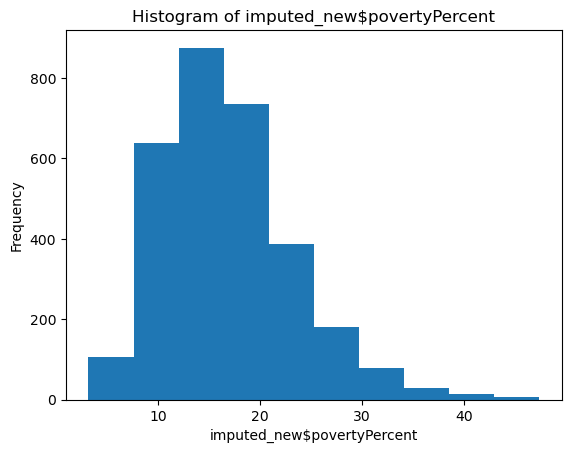

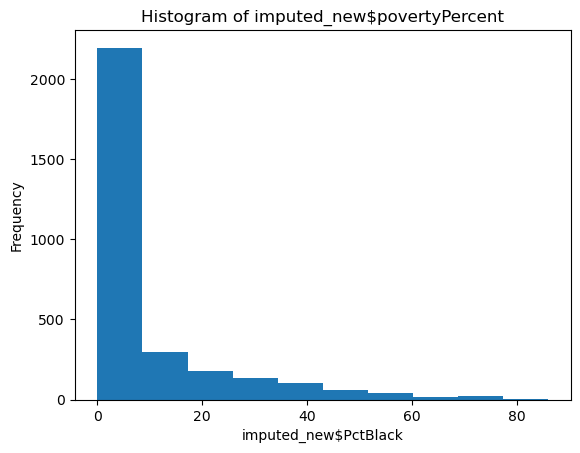

In [8]:
imputed_new = imputed_df.copy() # create a copy of imputed
import matplotlib.pyplot as plt # import the matplotlib library for plotting

plt.hist(imputed_new['povertyPercent'])
plt.title('Histogram of imputed_new$povertyPercent')
plt.xlabel('imputed_new$povertyPercent')
plt.ylabel('Frequency')
plt.show()

plt.hist(imputed_new['PctBlack'])
plt.title('Histogram of imputed_new$povertyPercent')
plt.xlabel('imputed_new$PctBlack')
plt.ylabel('Frequency')
plt.show()

In [9]:
import sklearn.linear_model as lm
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf

model = smf.ols(formula='TARGET_deathRate ~ povertyPercent + PctBlack + PctNoHS18_24 + PctHS18_24', data=imputed_new)
result = model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:       TARGET_deathRate   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     240.4
Date:                Tue, 09 May 2023   Prob (F-statistic):          1.39e-179
Time:                        06:44:52   Log-Likelihood:                -14031.
No. Observations:                3047   AIC:                         2.807e+04
Df Residuals:                    3042   BIC:                         2.810e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        127.5873      2.110     60.

The initial fit is rather weak, with a R-squared of 0.24. Let us code and add isSoutheast as a categorical variable. To define which states belong to the Southeast, we will be using the regions specified by the Bureau of Economic Analysis, who divide the United States into 8 regions. Finally, we will use ANOVA to discern whether this suggested categorical variable is significant to our regression.

In [10]:
Southeast = ["Alabama", "Arkansas", "Florida", "Georgia", "Kentucky", "Louisiana", "Mississippi", "North Carolina", "South Carolina", "Tennessee", "Virginia", "West Virginia"]
Southeast_int = [state_dict[x] for x in Southeast]
Southeast_int

[1, 4, 9, 10, 17, 18, 24, 33, 40, 42, 46, 48]

In [11]:
imputed_new['isSoutheast'] = imputed_new['State'].isin(Southeast_int).astype(int)
imputed_new

,avgAnnCount,avgDeathsPerYear,TARGET_deathRate,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,MedianAge,MedianAgeMale,...,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate,Target_div_Income,State,Target_div_LogIncome,isSoutheast
0,1397.000000,469.0,164.9,489.800000,61898.0,260131.0,11.2,499.748204,39.3,36.9,...,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831,0.002664,47.0,14.945742,0
1,173.000000,70.0,161.3,411.600000,48127.0,43269.0,18.6,23.111234,33.0,32.2,...,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096,0.003352,47.0,14.960676,0
2,102.000000,50.0,174.7,349.700000,49348.0,21026.0,14.6,47.560164,45.0,44.0,...,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488,0.003540,47.0,16.165968,0
3,427.000000,202.0,194.8,430.400000,44243.0,75882.0,17.1,342.637253,42.8,42.2,...,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841,0.004403,47.0,18.209943,0
4,57.000000,26.0,144.4,350.100000,49955.0,10321.0,12.5,0.000000,48.3,47.8,...,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657,0.002891,47.0,13.347040,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3042,1962.667684,15.0,149.6,453.549422,46961.0,6343.0,12.4,0.000000,44.2,41.1,...,90.280811,3.837754,0.327613,1.700468,51.063830,7.773512,0.003186,16.0,13.907129,0
3043,1962.667684,43.0,150.1,453.549422,48609.0,37118.0,18.8,377.175494,30.4,29.3,...,75.706245,2.326771,4.044920,14.130288,52.007937,8.186470,0.003088,16.0,13.909013,0
3044,1962.667684,46.0,153.9,453.549422,51144.0,34536.0,15.0,1968.959926,30.9,30.5,...,87.961629,2.313188,1.316472,5.680705,55.153949,7.809192,0.003009,16.0,14.194274,0
3045,1962.667684,52.0,175.0,453.549422,50745.0,25609.0,13.3,0.000000,39.0,36.9,...,92.905681,1.176562,0.244632,2.131790,58.484232,7.582938,0.003449,16.0,16.152005,0


In [12]:
model1 = smf.ols(formula='TARGET_deathRate ~ povertyPercent + PctBlack + PctNoHS18_24 + PctHS18_24 + isSoutheast', data=imputed_new)
result1 = model1.fit()

print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:       TARGET_deathRate   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     221.6
Date:                Tue, 09 May 2023   Prob (F-statistic):          4.65e-202
Time:                        06:44:52   Log-Likelihood:                -13976.
No. Observations:                3047   AIC:                         2.796e+04
Df Residuals:                    3041   BIC:                         2.800e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        130.1146      2.086     62.

To add variables of interest, we will be using Lasso regression using a Lambda 1 standard deviation away from the minimum residual deviance Lambda value, which will be obtained using cross-validation. Here is the graph of Lambda values, with the minimum Lambda at 0.1434, and the 1 SE Lambda value at 2.1288.

In [13]:
from sklearn.linear_model import LassoCV


y = imputed_new['TARGET_deathRate']
x = imputed_new[['povertyPercent', 'PctBlack', 'PctHS18_24',
                 'PctNoHS18_24', 'isSoutheast','PctPublicCoverage',
                 'PctPublicCoverageAlone', "PctUnemployed16_Over"]]

modelcvalpha = LassoCV(alphas = None, cv = 10, max_iter = 100000).fit(x, y)

alpha = getattr(modelcvalpha, 'alpha_')

In [14]:
newmodel = lm.Lasso(alpha=alpha)
newmodel = newmodel.fit(x, y)

coefs = getattr(newmodel, 'coef_')
coefs

array([ 6.18181993e-01,  6.51711241e-04,  4.98726850e-01, -1.89012910e-01,
        1.07662463e+01,  3.04999629e-01,  6.05695117e-01,  5.43496705e-01])

## bootstrapping

In [18]:
# # Create a function to calculate the coefficients using the bootstrap
# def bootstrap_model(data):
#     data_boot = data.sample(n=len(data), replace=True)
#     model = smf.ols(formula="TARGET_deathRate ~ povertyPercent + PctHS18_24 + isSoutheast + PctPublicCoverage + PctPublicCoverageAlone + PctUnemployed16_Over", data=data_boot).fit()
#     return model.params[1:]

povertyPercent = []
PctHS18_24 = []
isSoutheast = []
PctPublicCoverage = []
PctPublicCoverageAlone = []
PctUnemployed16_Over = []

for i in range(1000):
    bootparams = ls.bootstrap_model(imputed_new)
    povertyPercent += [bootparams[0]]
    PctHS18_24 += [bootparams[1]]
    isSoutheast += [bootparams[2]]
    PctPublicCoverage += [bootparams[3]]
    PctPublicCoverageAlone += [bootparams[4]]
    PctUnemployed16_Over += [bootparams[5]]
    
orig_params = smf.ols(formula="TARGET_deathRate ~ povertyPercent + PctHS18_24 + isSoutheast + PctPublicCoverage + PctPublicCoverageAlone + PctUnemployed16_Over", data=imputed_new).fit().params[1:]


In [19]:
#make df of results

bootdf = pd.DataFrame({'povertyPercent': povertyPercent,
                       'PctHS18_24': PctHS18_24,
                       'isSoutheast': isSoutheast,
                       'PctPublicCoverage': PctPublicCoverage,
                       'PctPublicCoverageAlone': PctPublicCoverageAlone,
                       'PctUnemployed16_Over': PctUnemployed16_Over})

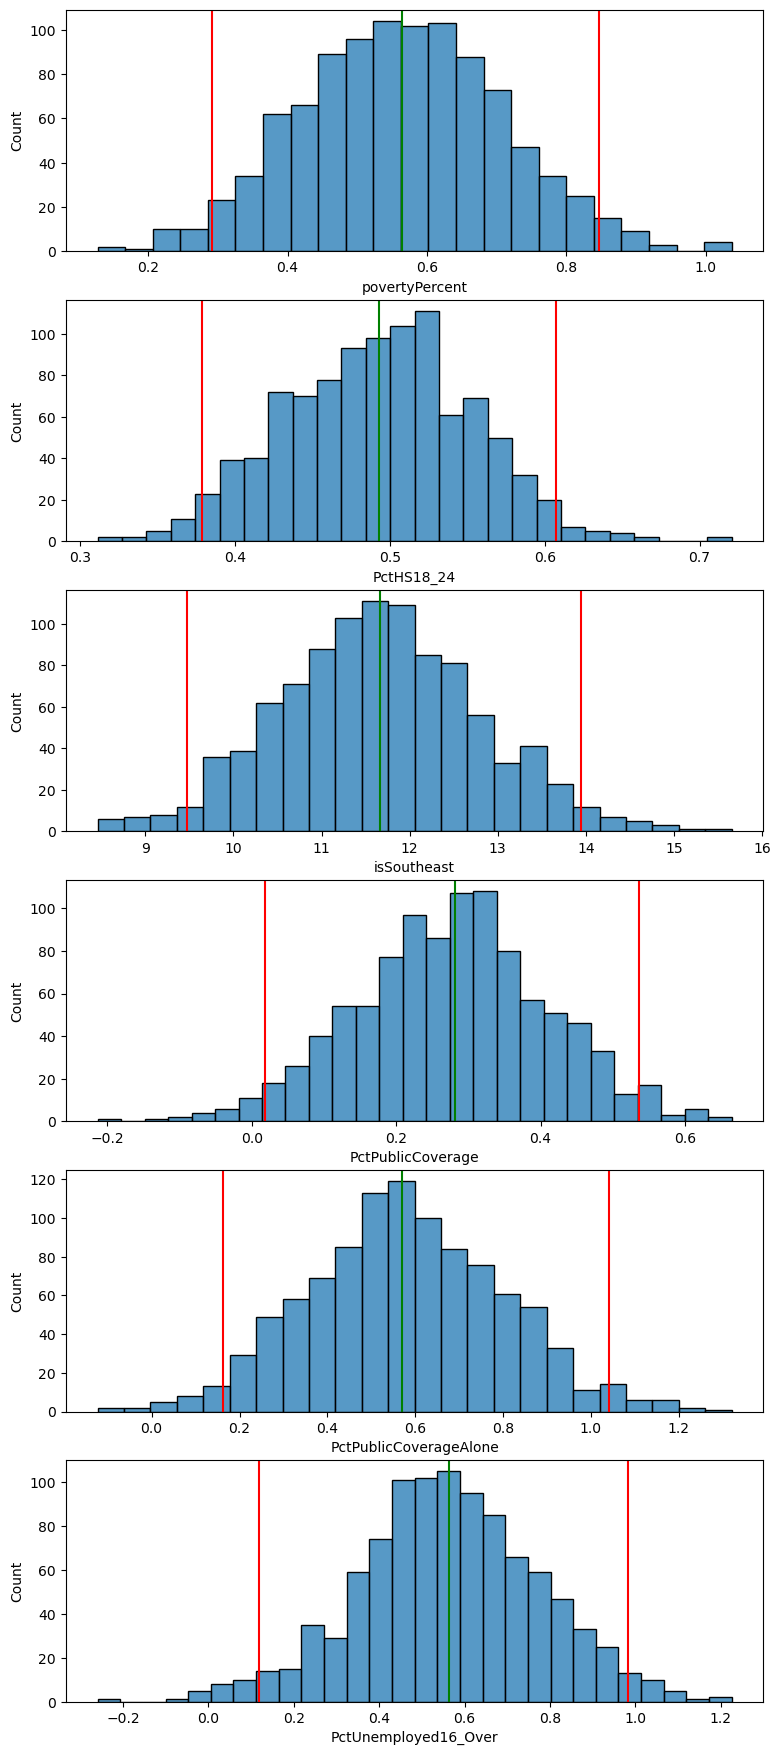

In [20]:
# plot SBS hists of vars in df

fig, axs = plt.subplots(6, 1, figsize=(9, 9))
plt.subplots_adjust(bottom=-1)

for i in range(len(bootdf.columns)):
    axs[i].axvline(x=np.percentile(bootdf[bootdf.columns[i]], 2.5), color='red')
    axs[i].axvline(x=np.percentile(bootdf[bootdf.columns[i]], 97.5), color='red')
    axs[i].axvline(x=orig_params[i], color='green')
    sns.histplot(data=bootdf, x=str(bootdf.columns[i]), ax=axs[i])